***Covid-19 Tracking by State***

This briefly demonstrates how the different methods in ctp.py work together to get data from the web, process it, and then graph the history of positive cases and deaths due to Covid-19 in the state of your choice. 

NOTE: If this is viewed long after the vaccine has been distributed and Covid-19 is no longer relevant, most of the graphs will likely be flat because there has been no change in the recent past. Unfortunately, that is not applicable to the time of me writing this

In [1]:
# Import libraries, may be important later

import ctp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Update the data folder to contain the latest data set
ctp.UpdateCovidTracking()

Date updated


In [3]:
# View the most recent data that we have (what we just updated)
df = ctp.LoadCTPData(update_first=False)

df.head()

,state,positive,death
date,,,
2021-01-18,AK,50447.0,229.0
2021-01-18,AL,424028.0,6121.0
2021-01-18,AR,272263.0,4343.0
2021-01-18,AS,0.0,0.0
2021-01-18,AZ,679282.0,11265.0


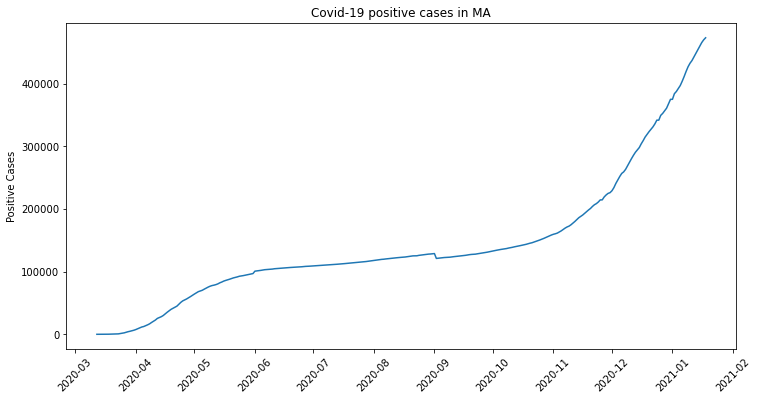


Total COVID-19 positive cases in MA: 473441
New COVID-19 positive cases in MA today: 3301


In [4]:
# Plot the data to show the amount of deaths over time in Massachusetts

state = "MA"
metric = "positive" # can be "death" for number of deaths or "positive" for total positive cases

ctp.ShowCovidTracking(state, metric, update_first=False)

# get state data
idx_state = df.state == state
df_current_state = df[idx_state].copy()
    
# Calculate new and total cases
new_cases = df_current_state[metric][0] - df_current_state[metric][1]
total_cases = df_current_state[metric][0]


# Print the number of cases for the metric    
if metric == "death":
    print("\nTotal COVID-19 deaths in " + state + ": " + str(int(df_current_state[metric][0])))
    print("New COVID-19 deaths in " + state + " in the past day: " + str(int(new_cases)))
else:
    print("\nTotal COVID-19 positive cases in " + state + ": " + str(int(df_current_state[metric][0])))
    print("New COVID-19 positive cases in " + state + " today: " + str(int(new_cases)))


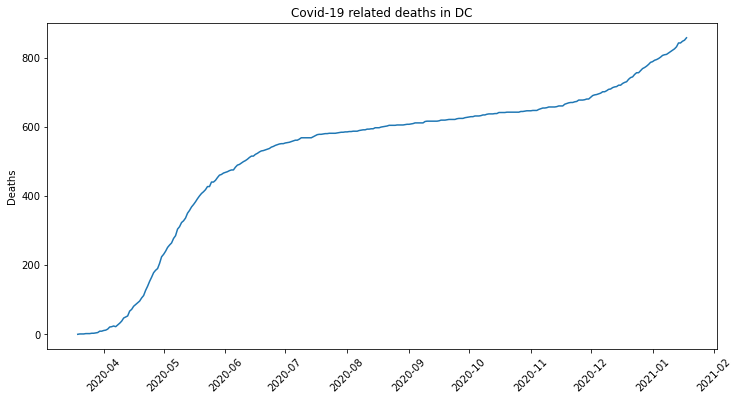


Total COVID-19 deaths in DC: 857
New COVID-19 deaths in DC in the past day: 7


In [5]:
# We can also look at death counts, using Washington DC as an example

state = 'DC'
metric = 'death'

ctp.ShowCovidTracking(state, metric, update_first=False)

# get state data
idx_state = df.state == state
df_current_state = df[idx_state].copy()
    
# Calculate new and total cases
new_cases = df_current_state[metric][0] - df_current_state[metric][1]
total_cases = df_current_state[metric][0]


# Print the number of cases for the metric    
if metric == "death":
    print("\nTotal COVID-19 deaths in " + state + ": " + str(int(df_current_state[metric][0])))
    print("New COVID-19 deaths in " + state + " in the past day: " + str(int(new_cases)))
else:
    print("\nTotal COVID-19 positive cases in " + state + ": " + str(int(df_current_state[metric][0])))
    print("New COVID-19 positive cases in " + state + " today: " + str(int(new_cases)))

***Predicting Future Death Tolls for Massachusetts with Polynomial Regression***

I use a polynomial regression model to predict what the death total in Massachusetts will be if positive test totals reach 500k, 1 million, and 5 million. This could be adjusted for any state, I just chose MA because this is where I grew up. 

In [6]:
# Start by extracting the data for the desired state

state = 'MA'

# get state data
idx_state = df.state == state
df_current_state = df[idx_state].copy()

df_current_state.head(5)

,state,positive,death
date,,,
2021-01-18,MA,473441.0,13705.0
2021-01-17,MA,470140.0,13652.0
2021-01-16,MA,465726.0,13583.0
2021-01-15,MA,459927.0,13509.0
2021-01-14,MA,454402.0,13433.0


In [7]:
# We are going to use the amount of positive test cases to predcit how many will die if tht=at number is reached
features = df_current_state['positive'][0:180] # use past 6 months for data
targets = df_current_state['death'][0:180]

# Training and Testing Splits
from sklearn.model_selection import train_test_split as tts
X_train, X_test, ytrain, ytest = tts(features, targets, test_size=0.4)


In [8]:
# Scale features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
Xtrain = poly.fit_transform(X_train.values.reshape(-1,1))
Xtest = poly.transform(X_test.values.reshape(-1,1))

# Perform linear regression
from sklearn.linear_model import LinearRegression as LR
lin_reg = LR()
lin_reg.fit(Xtrain, ytrain)

# Now compare the scores on the training and testing sets:
print('Internal Validity (R^2): ' + format(lin_reg.score(Xtrain, ytrain), '.3f'))
print('External Validity (R^2): ' + format(lin_reg.score(Xtest, ytest), '.3f'))

Internal Validity (R^2): 0.988
External Validity (R^2): 0.974


In [9]:
# What if we reach 500,000 positive tests? 1,000,000? 5,000,000?
prediction_vals = np.array([500000, 1000000, 5000000])
pred_vals = poly.transform(prediction_vals.reshape(-1,1))
x = lin_reg.predict(pred_vals)

In [10]:
print("Predicted death toll at 500,000 cases  : ", int(x[0]))
print("Predicted death toll at 1,000,000 cases: ", int(x[1]))
print("Predicted death toll at 5,000,000 cases: ", int(x[2]))

Predicted death toll at 500,000 cases  :  14571
Predicted death toll at 1,000,000 cases:  76104
Predicted death toll at 5,000,000 cases:  18099912


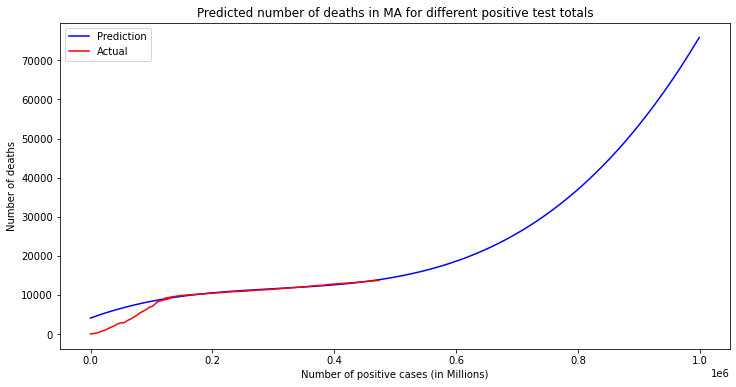

In [11]:
# We can make a graph for what will happen over 500,000 cases

new_points = np.arange(0, 1000000, 1000)
points = poly.transform(new_points.reshape(-1,1))
pred_points = lin_reg.predict(points)

plt.figure(figsize=(12,6))
plt.plot(points[:,1], pred_points, color='blue', label="Prediction")
plt.plot(df_current_state['positive'], df_current_state['death'], color='red', label = 'Actual')
plt.legend()
plt.ylabel("Number of deaths")
plt.xlabel("Number of positive cases (in Millions)")
plt.title("Predicted number of deaths in " + state + " for different positive test totals")
plt.show()

**Quick Conclusion (Regression)**

The graph highlights that if nothing changes, this is going to continue to get out of control very fast. Luckily there is some hope with the vaccine just starting to be distributed (at the time of me writing this), but that seems to be the only hope we have based on the path we have been taking so far. 

This is by no means a perfect analysis. The next step is to do a time series analysis. This will give more insight to how long it would take to reach different milestones, such as 500,000 or 1,000,000 positive test cases in MA. 

***Neural Network Prediction***

Functioning as an exploratory introduction to time series analysis

In [12]:
import numpy as np

# Isolate death data for predictiions
training_set = df_current_state['death'].values

# scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))

In [13]:
# Create trainging set for features and labels
features = []
labels = []

for i in range(30,240):
    features.append(training_set_scaled[i:i+10])
    labels.append(training_set_scaled[i])
    
features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

**Building the Model**

In [14]:
# Import libraries (May need to install two packages below with the commented commands)
#%pip install keras
#%pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [15]:
# Create the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features.shape[1], 1)))
model.add(Dropout(0.2)) # prevent overfitting

model.add(LSTM(units=50, input_shape=(features.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [16]:
# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(features, labels, epochs=50, batch_size=12)

Epoch 1/50
18/18 [==============================] - 4s 15ms/step - loss: 0.2486
Epoch 2/50
18/18 [==============================] - 0s 21ms/step - loss: 0.0116
Epoch 3/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0078
Epoch 4/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0045
Epoch 5/50
18/18 [==============================] - 0s 17ms/step - loss: 0.0048
Epoch 6/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0054
Epoch 7/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0045
Epoch 8/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0044
Epoch 9/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0048
Epoch 10/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0044
Epoch 11/50
18/18 [==============================] - 0s 18ms/step - loss: 0.0035
Epoch 12/50
18/18 [==============================] - 0s 20ms/step - loss: 0.0046
Epoch 13/50
18/18 [==================

**Predicting Death Tolls**

I'll use the same range of values as with the polynomial regression from 500k cases to 1 million positive cases in MA

In [17]:
X_test = []
y_test = []

for i in range(0,30):
    X_test.append(training_set_scaled[i:i+10])
    y_test.append(training_set[i])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
# Predict values and undo the scaling that implemented
predicted_vals = model.predict(X_test)
predicted_vals = sc.inverse_transform(predicted_vals)


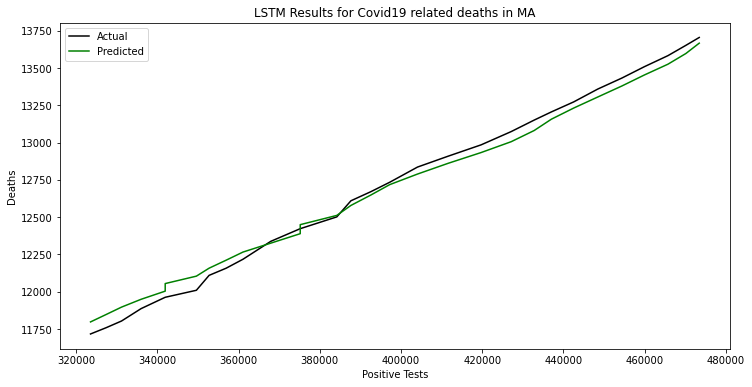

In [19]:
# Plot the results!
plt.figure(figsize=(12,6))
plt.plot(df_current_state['positive'][0:30], y_test, color = 'black', label = 'Actual')
plt.plot(df_current_state['positive'][0:30], predicted_vals, color = 'green', label = 'Predicted')
plt.title('LSTM Results for Covid19 related deaths in ' + state)
plt.xlabel('Positive Tests')
plt.ylabel('Deaths')
plt.legend()
plt.show()


***Quick Conlusion (Nerual Network)***

So this is by no means a perfect model, and there are probably better and more efficient ways I could come to this conclusion or level of prediction power. I'm using this as an introduction to time series analysis where I am using previous data points to predict what the next one is. This is my first experience with this time of analysis, so the goal was just to get my hands dirty and explore a little, which I feel I have accomplished. 